# Préparation et nettoyage des données communales (codes INSEE + coordonnées)

---

## **Introduction**

### **Objectif de ce notebook**

Ce notebook a pour objectif de préparer et nettoyer les données communales françaises,
afin d’obtenir une table claire contenant :
- le code INSEE de chaque commune,
- son nom,
- son code département et région,
- ses coordonnées géographiques (latitude, longitude).

Ces données serviront à relier d’autres jeux de données (comme les loyers ou DVF)
via code_commune_INSEE pour des analyses géographiques.

### **Sources de données utilisées**

- Fichier : data/20230823-communes-departement-region.csv ([télécharger directement](https://www.data.gouv.fr/api/1/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25))

- Origine : Base officielle des communes françaises (INSEE / data.gouv.fr)

- Source : 
https://www.data.gouv.fr/datasets/communes-de-france-base-des-codes-postaux/


---

## **Import des bibliotheques**


In [ ]:
# Manipulation de données
import pandas as pd
import geopandas as gpd

# Visualisation
import matplotlib.pyplot as plt

# Utilitaires
from shapely.geometry import Point

---

## **Chargement des donnees brutes**

### **Chargement du fichier**

In [ ]:

def load_data():
    communes = pd.read_csv("data/20230823-communes-departement-region.csv", sep=",", low_memory=False)
    print(f"✅ Fichier chargé avec succès : {communes.shape[0]} lignes, {communes.shape[1]} colonnes.")
    return communes

communes_raw = load_data()

✅ Fichier chargé avec succès : 39201 lignes, 15 colonnes.


---

## Exploration initiale des donnees

### Structure du dataset


In [ ]:
def initial_exploration(df, dataset_name= "Dataset"):
    
    print(f"\nStructure du dataset : {dataset_name}")
    
    print(f"Nombre de lignes : {df.shape[0]}")
    print(f"Nombre de colonnes : {df.shape[1]}")

    print("Noms des colonnes :")
    print(df.columns.tolist())
    
    print("Types de données :")
    print(df.dtypes)
    

initial_exploration(communes_raw, "Communes")



Structure du dataset : Communes
Nombre de lignes : 39201
Nombre de colonnes : 15
Noms des colonnes :
['code_commune_INSEE', 'nom_commune_postal', 'code_postal', 'libelle_acheminement', 'ligne_5', 'latitude', 'longitude', 'code_commune', 'article', 'nom_commune', 'nom_commune_complet', 'code_departement', 'nom_departement', 'code_region', 'nom_region']
Types de données :
code_commune_INSEE       object
nom_commune_postal       object
code_postal               int64
libelle_acheminement     object
ligne_5                  object
latitude                float64
longitude               float64
code_commune            float64
article                  object
nom_commune              object
nom_commune_complet      object
code_departement         object
nom_departement          object
code_region             float64
nom_region               object
dtype: object


### Analyse des colonnes


In [ ]:
def analyze_columns(df, dataset_name="Dataset"):
   
    print(f"\n Analyse des colonnes pour : {dataset_name}")
    
    # Boucle sur chaque colonne
    for col in df.columns:
        print(f"\n Colonne : {col}")
        print(f"   ➜ Type : {df[col].dtype}")
        print(f"   ➜ Valeurs manquantes : {df[col].isna().sum()}")
        print(f"   ➜ Valeurs uniques : {df[col].nunique()}")
    

analyze_columns(communes_raw, "Transports IDF")


 Analyse des colonnes pour : Transports IDF

 Colonne : code_commune_INSEE
   ➜ Type : object
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 36013

 Colonne : nom_commune_postal
   ➜ Type : object
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 33527

 Colonne : code_postal
   ➜ Type : int64
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 6329

 Colonne : libelle_acheminement
   ➜ Type : object
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 33675

 Colonne : ligne_5
   ➜ Type : object
   ➜ Valeurs manquantes : 35944
   ➜ Valeurs uniques : 3042

 Colonne : latitude
   ➜ Type : float64
   ➜ Valeurs manquantes : 269
   ➜ Valeurs uniques : 35921

 Colonne : longitude
   ➜ Type : float64
   ➜ Valeurs manquantes : 269
   ➜ Valeurs uniques : 35921

 Colonne : code_commune
   ➜ Type : float64
   ➜ Valeurs manquantes : 7
   ➜ Valeurs uniques : 908

 Colonne : article
   ➜ Type : object
   ➜ Valeurs manquantes : 36621
   ➜ Valeurs uniques : 6

 Colonne : nom_commune
   ➜ Type : ob


**Colonnes essentielles**

Les colonnes essentielles pour l’analyse centrée sur la localisation des transports sont :

**code_commune_INSEE** → Code unique par commune  **CRITIQUE**

**code_departement** → Département **IMPORTANTE**

**latitude, longitude** → coordonnées géographiques **CRITIQUE**


---

## Nettoyage des donnees

### Sélection des colonnes pertinentes

In [ ]:
def select_relevant_columns(df):
    
    colonnes_utiles = [
        "code_commune_INSEE", "latitude", "longitude","code_departement", "nom_departement"
    ]
    df = df[colonnes_utiles]

    print(" Colonnes pertinentes sélectionnées avec succès")
    print("Colonnes sélectionnées :", list(df.columns))
    print(f"Nombre de lignes : {len(df)}")

    return df

communes_sel = select_relevant_columns(communes_raw)

 Colonnes pertinentes sélectionnées avec succès
Colonnes sélectionnées : ['code_commune_INSEE', 'latitude', 'longitude', 'code_departement', 'nom_commune']
Nombre de lignes : 39201


### Filtrer pour IDF


In [ ]:
def filter_idf(df):
   
    # Codes INSEE des départements d'Île-de-France
    departements_idf = ["75", "77", "78", "91", "92", "93", "94", "95"]

    # On crée une copie explicite pour éviter le SettingWithCopyWarning
    df = df.copy()

    # Conversion du code département en chaîne de caractères
    df.loc[:, "code_departement"] = df["code_departement"].astype(str)

    # Filtrage des communes d'Île-de-France
    df_idf = df[df["code_departement"].isin(departements_idf)].copy()

    print(f"➡ {len(df_idf)} communes appartiennent à l’Île-de-France.")
    print("Répartition par département :")
    print(df_idf["code_departement"].value_counts().sort_index())

    return df_idf

# Exécution
communes_idf = filter_idf(communes_sel)


➡ 1383 communes appartiennent à l’Île-de-France.
Répartition par département :
code_departement
75     21
77    544
78    283
91    208
92     41
93     41
94     51
95    194
Name: count, dtype: int64


### Gestion des valeures manquantes 



In [ ]:
def clean_missing_duplicates(df):
    print("\nNettoyage des doublons et valeurs manquantes...")

    avant = len(df)
    df = df.dropna(subset=["latitude", "longitude"])
    print(f" Coordonnées manquantes supprimées (lignes restantes : {len(df)})")
    print(f"→ {avant - len(df)} valeurs manquantes supprimées")
    return df

communes_no_missing_value = clean_missing_duplicates(communes_idf)



Nettoyage des doublons et valeurs manquantes...
 Coordonnées manquantes supprimées (lignes restantes : 1383)
→ 0 valeurs manquantes supprimées


### Suppression des doublons

In [ ]:
def remove_duplicates(df):
    
    print("\n Suppression des doublons...")

    avant = len(df)
    df = df.drop_duplicates(subset=['code_commune_INSEE'])
    print(f"→ {avant - len(df)} doublons supprimés")
    
    return df

communes_no_duplicates = remove_duplicates(communes_no_missing_value)


 Suppression des doublons...
→ 86 doublons supprimés


### Conversion des types de données


In [ ]:
def convert_data_types(df):
    
    print("\n Conversion des types de données...")

    df = df.copy()

    # Conversion des coordonnées en float
    df.loc[:, "latitude"] = df["latitude"].astype(float)
    df.loc[:, "longitude"] = df["longitude"].astype(float)
    
    # Normalisation du code INSEE sur 5 chiffres
    df.loc[:, "code_commune_INSEE"] = df["code_commune_INSEE"].astype(str).str.zfill(5)

    print("✅ Conversion terminée avec succès !")
    print(df.dtypes[["latitude", "longitude", "code_commune_INSEE"]])
    
    return df

communes_final = convert_data_types(communes_no_duplicates)


 Conversion des types de données...
✅ Conversion terminée avec succès !
latitude              float64
longitude             float64
code_commune_INSEE     object
dtype: object


---

## Transformation 

### Création de variables dérivées 

In [ ]:
def transform_data(df):
    print("\n Transformation des données...")

    df = df.rename(columns={
        "code_commune_INSEE": "INSEE_COM"
    })


    print(" Colonnes renommées.")
    print(f"Colonnes finales : {list(df.columns)}")
    return df

communes_rename = transform_data(communes_final)



 Transformation des données...
 Colonnes renommées.
Colonnes finales : ['INSEE_COM', 'latitude', 'longitude', 'code_departement', 'nom_commune']


### Conversion en GeoDataFrame

In [ ]:
def to_geodataframe(df):
    print("\n Conversion en GeoDataFrame...")

    print("\n--- Conversion en GeoDataFrame ---")
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326"
    )
    print(f"✅ Conversion réussie ({len(gdf)} points).")
    return gdf


# Création du GeoDataFrame corrigé
communes_gdf = to_geodataframe(communes_rename)



 Conversion en GeoDataFrame...

--- Conversion en GeoDataFrame ---
✅ Conversion réussie (1297 points).


---

## Analyses statistiques descriptives

### Statistiques globales

In [ ]:
def describe_communes(df):
    print(f"Nombre de communes : {len(df)}")
    print(f"Départements présents : {df['code_departement'].nunique()}")
    print("\nÉtendue géographique :")
    print(f"Latitude : {df['latitude'].min():.3f} → {df['latitude'].max():.3f}")
    print(f"Longitude : {df['longitude'].min():.3f} → {df['longitude'].max():.3f}")

describe_communes(communes_gdf)



Nombre de communes : 1297
Départements présents : 8

Étendue géographique :
Latitude : 48.141 → 49.213
Longitude : 1.481 → 3.489


---

## Visualisations exploratoires





--- Visualisation rapide ---


<Figure size 600x600 with 0 Axes>

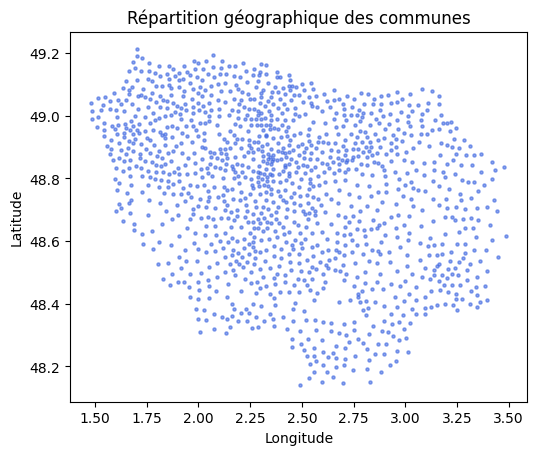

In [ ]:
def spatial_distribution(gdf):

    print("\n--- Visualisation rapide ---")
    plt.figure(figsize=(6,6))
    gdf.plot(markersize=5, color="royalblue", alpha=0.6)
    plt.title("Répartition géographique des communes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

spatial_distribution(communes_gdf)

---

## Export des donnees nettoyees

### Sauvegarde du dataset final

In [ ]:
communes_gdf.to_file("data/cleaned/communes_coordonnees.geojson", driver="GeoJSON")
communes_final.to_csv("data/cleaned/communes.csv", index=False)
print(f" Dataset nettoyé exporté : communes_final.csv - {communes_final.shape[0]} lignes, {communes_final.shape[1]} colonnes")
print(f" Fichier exporté : data/communes_coordonnees.geojson ({len(communes_gdf)} lignes)")


 Dataset nettoyé exporté : communes_final.csv - 1297 lignes, 5 colonnes
 Fichier exporté : data/communes_coordonnees.geojson (1297 lignes)


In [ ]:
communes_final

,code_commune_INSEE,latitude,longitude,code_departement,nom_commune
32613,75101,48.862630,2.336293,75,Paris 01
32614,75102,48.867903,2.344107,75,Paris 02
32615,75103,48.863054,2.359361,75,Paris 03
32616,75104,48.854228,2.357362,75,Paris 04
32617,75105,48.844509,2.349859,75,Paris 05
...,...,...,...,...,...
38720,95676,49.085900,1.730396,95,Villers-en-Arthies
38721,95678,49.070289,2.239509,95,Villiers-Adam
38722,95680,49.008449,2.403856,95,Villiers-le-Bel
38723,95682,49.074309,2.386890,95,Villiers-le-Sec


---

## Synthese du nettoyage

### Résumé des transformations effectuées


1.	**Données brutes initiales :** 39201 lignes, 15 colonnes  
2.	**Après filtre IDF:**  1383 lignes 
3. **Après suppression des valeurs manquantes critiques :** 
   0 lignes supprimées  
4. **Après suppression des doublons de code_commune_INSEE :** 86 doublons supprimés  
5. **Colonnes finales:**  
   'INSEE_COM', 'latitude', 'longitude', 'code_departement', 'geometry'
   avec 1297 lignes
6. **Nouvelles variables créées :**  
   - `geometry` : point géographique à partir des coordonnées  
7. **Format final :** GeoDataFrame (projection WGS84 – EPSG:4326)



### Qualité des données finales

In [ ]:
print("\n--- Vérification finale de la qualité des données ---")

missing_total = communes_gdf.isna().sum().sum()
print(f"- Valeurs manquantes totales : {missing_total}")

print(f"- Nombre total de communes : {len(communes_gdf)}")
print(f"- Nombre de départements : {communes_gdf['code_departement'].nunique()}")

print("\nÉtendue géographique (Île-de-France) :")
print(f"Latitude  : {communes_gdf['latitude'].min():.4f} → {communes_gdf['latitude'].max():.4f}")
print(f"Longitude : {communes_gdf['longitude'].min():.4f} → {communes_gdf['longitude'].max():.4f}")

print("\nColonnes finales :")
print(list(communes_gdf.columns))
print("\nTypes de données :")
print(communes_gdf.dtypes[['INSEE_COM', 'longitude', 'latitude', 'code_departement']])




--- Vérification finale de la qualité des données ---
- Valeurs manquantes totales : 0
- Nombre total de communes : 1297
- Nombre de départements : 8

Étendue géographique (Île-de-France) :
Latitude  : 48.1408 → 49.2132
Longitude : 1.4806 → 3.4892

Colonnes finales :
['INSEE_COM', 'latitude', 'longitude', 'code_departement', 'nom_commune', 'geometry']

Types de données :
INSEE_COM            object
longitude           float64
latitude            float64
code_departement     object
dtype: object


### Recommandations pour l'analyse

Les variables les plus importantes pour la suite sont :

INSEE_COM → clé unique pour relier aux loyers ou aux biens DVF

latitude, longitude → pour la localisation géographique

geometry → utile pour cartographie et jointures spatiales


---

**Notebook préparé par :**
- Ashley OHNONA
- Harisoa RANDRIANASOLO
- Fairouz YOUDARENE
- Jennifer ZAHORA

**Date :** 16/10/2025

**Dataset final :** `communes_coordonnees.geojson`